In [116]:
# Importamos las bibliotecas generales

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn
 
# Importamos los módulos específicos
from sklearn.cluster import MeanShift
from sklearn.cluster import MiniBatchKMeans
 
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor, HuberRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [78]:

import warnings
warnings.simplefilter("ignore")

In [27]:
# Cargamos los datos del dataframe de pandas
dt_heart = pd.read_csv('data/heart.csv')

# Imprimimos un encabezado con los primeros 5 registros
dt_heart.head(5)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [28]:

# Guardamos nuestro dataset sin la columna de target
dt_features = dt_heart.drop(['target'], axis=1)
# Este será nuestro dataset, pero sin la columna
dt_target = dt_heart['target']

# Normalizamos los datos
dt_features = StandardScaler().fit_transform(dt_features)

# Partimos el conjunto de entrenamiento. Para añadir replicabilidad usamos el random state
X_train, X_test, y_train, y_test = train_test_split(dt_features, dt_target, test_size=0.3, random_state=42)
# Consultamos la fórmula para nuestra tabla
print(X_train.shape)
print(y_train.shape)

(717, 13)
(717,)


# Optimización de features

In [29]:
# Llamamos y configuramos nuestro algoritmo pca
'''EL número de componentes es opcional, ya que por defecto si no le pasamos el número de componentes lo asignará de esta forma:
a: n_components = min(n_muestras, n_features)'''
pca = PCA(n_components=3)
# Esto para que nuestro PCA se ajuste a los datos de entrenamiento que tenemos como tal
pca.fit(X_train)


PCA(n_components=3)

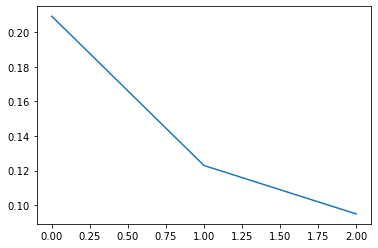

In [30]:
#Como haremos una comparación con incremental PCA, haremos lo mismo para el IPCA.
'''EL parámetro batch se usa para crear pequeños bloques, de esta forma podemos ir entrenandolos
poco a poco y combinarlos en el resultado final'''
ipca = IncrementalPCA(n_components=3, batch_size=10)
#Esto para que nuestro PCA se ajuste a los datos de entrenamiento que tenemos como tal
ipca.fit(X_train)
''' Aquí graficamos los números de 0 hasta la longitud de los componentes que me sugirió el PCA o que
me generó automáticamente el pca en el eje x, contra en el eje y, el valor de la importancia
en cada uno de estos componentes, así podremos identificar cuáles son realmente importantes
para nuestro modelo '''
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.show()


In [31]:
#Ahora vamos a configurar nuestra regresión logística
logistic = LogisticRegression(solver='lbfgs')

# Configuramos los datos de entrenamiento
dt_train = pca.transform(X_train)
dt_test = pca.transform(X_test)

# Mandamos los data frames la la regresión logística
logistic.fit(dt_train, y_train)

#Calculamos nuestra exactitud de nuestra predicción
print("SCORE PCA: ", logistic.score(dt_test, y_test))

#Configuramos los datos de entrenamiento
dt_train = ipca.transform(X_train)
dt_test = ipca.transform(X_test)

# Mandamos los data frames la la regresión logística
logistic.fit(dt_train, y_train)

#Calculamos nuestra exactitud de nuestra predicción
print("SCORE IPCA: ", logistic.score(dt_test, y_test)) 

SCORE PCA:  0.7857142857142857
SCORE IPCA:  0.8051948051948052


## Kernels y KPCA

In [32]:
#Aplicamos la función de kernel de tipo polinomial
kpca = KernelPCA(n_components=4, kernel='poly' )
#Vamos a ajustar los datos
kpca.fit(X_train)

#Aplicamos el algoritmo a nuestros datos de prueba y de entrenamiento
dt_train = kpca.transform(X_train)
dt_test = kpca.transform(X_test)

#Aplicamos la regresión logística un vez que reducimos su dimensionalidad
logistic = LogisticRegression(solver='lbfgs')

#Entrenamos los datos
logistic.fit(dt_train, y_train)

#Imprimimos los resultados
print("SCORE KPCA: ", logistic.score(dt_test, y_test))

SCORE KPCA:  0.7987012987012987


## Implementación de Lasso y Ridge

In [33]:
dataset = pd.read_csv('./data/felicidad.csv')
# Mostramos el reporte estadistico
dataset.describe()


,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,78.000000,5.354019,5.452326,5.255713,0.984718,1.188898,0.551341,0.408786,0.246883,0.123120,1.850238
std,44.888751,1.131230,1.118542,1.145030,0.420793,0.287263,0.237073,0.149997,0.134780,0.101661,0.500028
min,1.000000,2.693000,2.864884,2.521116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377914
25%,39.500000,4.505500,4.608172,4.374955,0.663371,1.042635,0.369866,0.303677,0.154106,0.057271,1.591291
50%,78.000000,5.279000,5.370032,5.193152,1.064578,1.253918,0.606042,0.437454,0.231538,0.089848,1.832910
75%,116.500000,6.101500,6.194600,6.006527,1.318027,1.414316,0.723008,0.516561,0.323762,0.153296,2.144654
max,155.000000,7.537000,7.622030,7.479556,1.870766,1.610574,0.949492,0.658249,0.838075,0.464308,3.117485


In [34]:
# Vamos a elegir los features que vamos a usar
X = dataset[['gdp', 'family', 'lifexp', 'freedom' , 'corruption' , 'generosity', 'dystopia']]
# Definimos nuestro objetivo, que sera nuestro data set, pero solo en la columna score 
y = dataset[['score']]

# Imprimimos los conjutos que creamos 
# En nuestros features tendremos definidos 155 registros, uno por cada pais, 7 colunas 1 por cada pais 
print(X.shape)
# Y 155 para nuestra columna para nuestro target 
print(y.shape)

(155, 7)
(155, 1)


In [35]:

# Aquí vamos a partir nuestro entrenaminto en training y test, no hay olvidar el orden
# Con el test size elejimos nuestro porcetaje de datos para training 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

# Aquí definimos nuestros regresores uno por 1 y llamamos el fit o ajuste 
modelLinear = LinearRegression().fit(X_train, y_train)
# Vamos calcular la prediccion que nos bota con la funcion predict con la regresion lineal 
# y le vamos a mandar el test 
y_predict_linear = modelLinear.predict(X_test)

# Configuramos alpha, que es valor labda y entre mas valor tenga alpha en lasso mas penalizacion 
# vamos a tener y lo entrenamos con la función fit 
modelLasso = Lasso(alpha=0.2).fit(X_train, y_train)
# Hacemos una prediccion para ver si es mejor o peor de lo que teniamos en el modelo lineal sobre
# exactamente los mismos datos que teníamos anteriormente 
y_predict_lasso = modelLasso.predict(X_test)

# Hacemos la misma predicción, pero para nuestra regresion ridge 
modelRidge = Ridge(alpha=1).fit(X_train, y_train)
# Calculamos el valor predicho para nuestra regresión ridge 
y_predict_ridge = modelRidge.predict(X_test)

# Calculamos la perdida para cada uno de los modelos que entrenamos, empezaremos con nuestro modelo 
# lineal, con el error medio cuadratico y lo vamos a aplicar con los datos de prueba con la prediccion 
# que hicimos 
linear_loss = mean_squared_error(y_test, y_predict_linear)
# Mostramos la perdida lineal con la variable que acabamos de calcular
print("Linear loss: ", linear_loss) 

# Mostramos nuestra perdida Lasso, con la variable lasso loss 
lasso_loss = mean_squared_error(y_test, y_predict_lasso)
print("Lasso Loss. ", lasso_loss) 

# Mostramos nuestra perdida de Ridge con la variable lasso loss 
ridge_loss = mean_squared_error(y_test, y_predict_ridge)
print("Ridge loss: ", ridge_loss)

# Imprimimos las coficientes para ver como afecta a cada una de las regresiones 
# La lines "="*32 lo unico que hara es repetirme si simbolo de igual 32 veces 
print("="*32)
print("Coeficientes lasso: ")
# Esta informacion la podemos encontrar en la variable coef_ 
print(modelLasso.coef_)

# Hacemos lo mismo con ridge 
print("="*32)
print("Coeficientes ridge:")
print(modelRidge.coef_)

Linear loss:  9.126458373430246e-08
Lasso Loss.  0.3757835997252115
Ridge loss:  0.00624221020122192
Coeficientes lasso: 
[1.08374607 0.         0.         0.         0.         0.
 0.33793172]
Coeficientes ridge:
[[1.06969259 0.95635604 0.87828099 0.90812629 0.61963184 0.72991277
  0.97298967]]


## Elastic Net

/tmp/ipykernel_633/757035893.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  modelElastic.fit(X_train, y_train)
/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


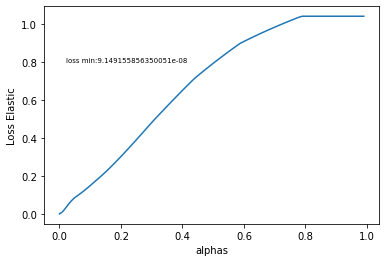

In [36]:
# elasticnet model

def modelElastic(alpha=1):
    modelElastic= ElasticNet(random_state=0, alpha=alpha)
    modelElastic.fit(X_train, y_train)
    y_predic_elastic=modelElastic.predict(X_test)
    # loss function
    elastic_loss = mean_squared_error(y_test, y_predic_elastic)
    return elastic_loss

alphas = np.arange(0,1,0.01)
loss_total = []
for i in alphas:
    res = modelElastic(i)
    loss_total.append(res)

loss_total = np.array(loss_total)
plt.plot(alphas, loss_total)
plt.xlabel('alphas')
plt.ylabel('Loss Elastic')
plt.text(0.02, 0.8, 'loss min:{}'.format(np.min(loss_total)), fontsize=7)
plt.show()

In [37]:
X = dataset[['gdp', 'family', 'lifexp', 'freedom',
                'corruption', 'generosity', 'dystopia']]
y = dataset[['score']]

# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

modelLinear = LinearRegression().fit(X_train, y_train)
y_pred_linear = modelLinear.predict(X_test)

modelLasso = Lasso(alpha=0.02).fit(X_train, y_train)
y_pred_lasso = modelLasso.predict(X_test)

modelRidge = Ridge(alpha=1).fit(X_train, y_train)
y_pred_ridge = modelRidge.predict(X_test)

modelElasticNet = ElasticNet(random_state=0).fit(X_train, y_train)
y_pred_elastic = modelElasticNet.predict(X_test)

linear_loss = mean_squared_error(y_test, y_pred_linear)
print('Linear Loss: ', linear_loss)

lasso_loss = mean_squared_error(y_test, y_pred_lasso)
print('Lasso Loss: ', lasso_loss)

ridge_loss = mean_squared_error(y_test, y_pred_ridge)
print('Ridge Loss: ', ridge_loss)

elastic_loss = mean_squared_error(y_test, y_pred_elastic)
print('ElasticNet Loss: ', elastic_loss)

print('='*32, '\n')
print("Coef Linear: ", modelLinear.coef_)
print("Coef Lasso: ", modelLasso.coef_)
print("Coef Ridge: ", modelRidge.coef_)
print("Coef Elastic: ", modelElasticNet.coef_)

Linear Loss:  9.113627069632848e-08
Lasso Loss:  0.04613142141272008
Ridge Loss:  0.005158990858509747
ElasticNet Loss:  1.1991244060565747

Coef Linear:  [[1.00012822 0.99987164 0.9999141  1.00013558 0.9996458  1.00007078
  0.99987976]]
Coef Lasso:  [1.35269253 0.86910384 0.37857477 0.83535984 0.         0.22914234
 0.90887934]
Coef Ridge:  [[1.08843372 0.95300018 0.84338277 0.90422291 0.64360573 0.76090281
  0.96456701]]
Coef Elastic:  [0. 0. 0. 0. 0. 0. 0.]


# Regresiones Robustas
## Problema de valores atípicos

/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sex', ylabel='chol'>

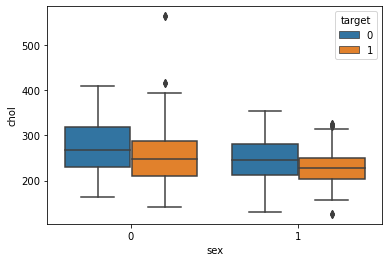

In [38]:
sns.boxplot(dt_heart.sex, dt_heart.chol, hue = dt_heart.target)

<AxesSubplot:>

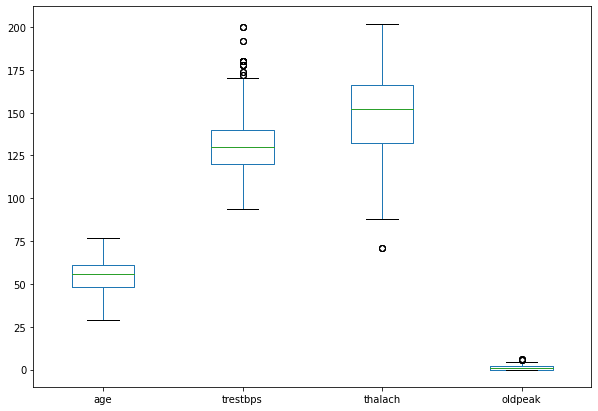

In [40]:
num_features = dt_heart[['age', 'trestbps', 'thalach', 'oldpeak']]
num_features

plt.figure(figsize=(10,7))
num_features.boxplot(grid=False)

<AxesSubplot:>

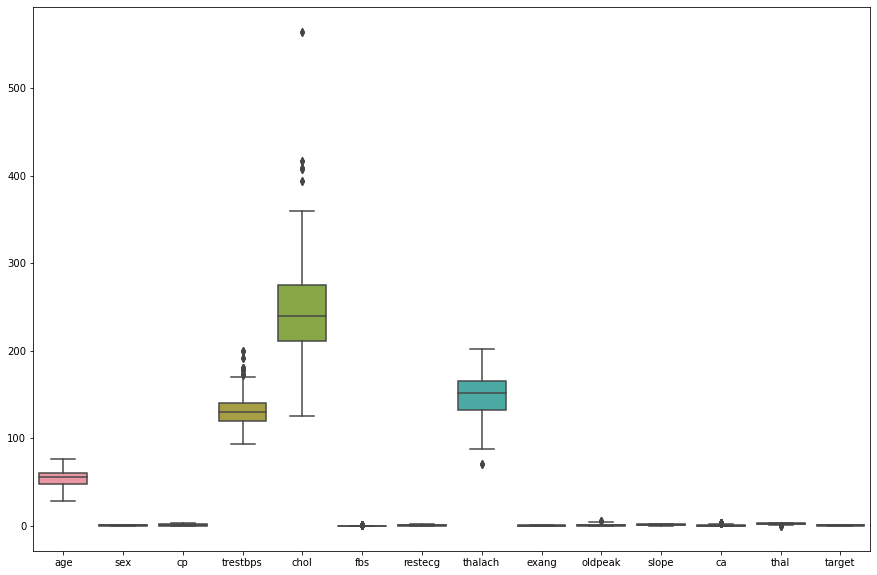

In [44]:
plt.figure(figsize=(15,10))
sns.boxplot(data=dt_heart)

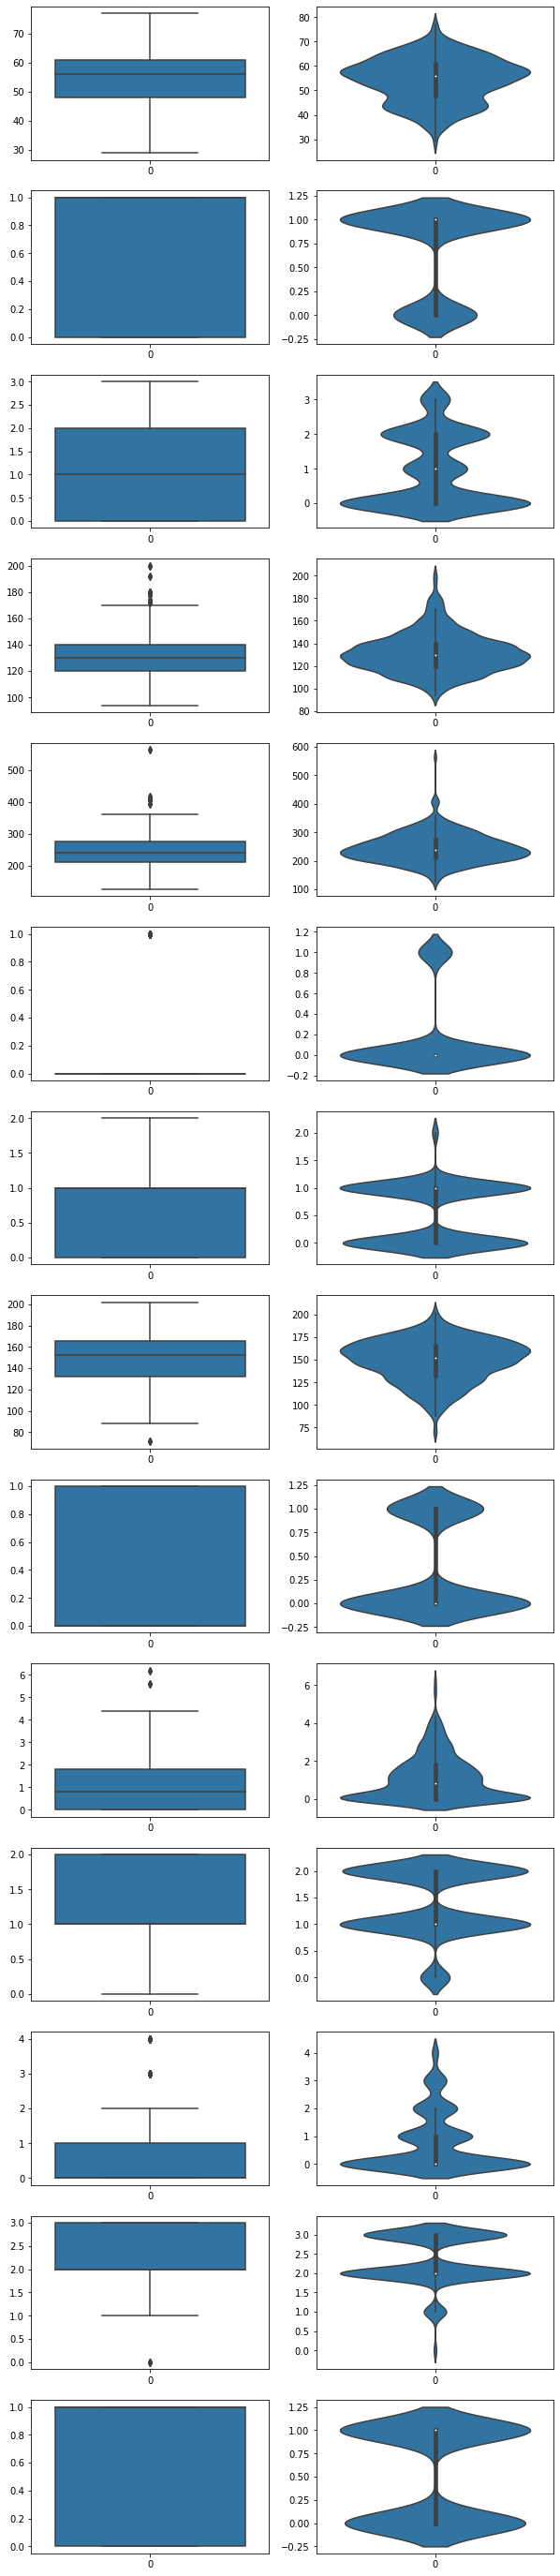

In [60]:
n_cols = len(dt_heart.columns)
plt.figure(figsize=(10,50))
for i, col in enumerate(dt_heart.columns):
    
    plt.subplot(n_cols,2,2*i+1)
    sns.boxplot(data=dt_heart[col])
    plt.subplot(n_cols,2,2*i+2)
    sns.violinplot(data=dt_heart[col])


## Preparación Regresiones Robustas

In [63]:
df_happy_c = pd.read_csv('data/felicidad_corrupt.csv')
df_happy_c.tail()

,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
162,H,163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,I,164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,J,165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,K,166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,L,167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X = df_happy_c.drop(['country','score'],axis=1)
y = df_happy_c.score

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [66]:
estimadores = {
    'SVR' : SVR(gamma='auto', C=1, epsilon=0.1),
    'RANSAC' : RANSACRegressor(),
    'HUBER' : HuberRegressor(epsilon=1.35)
}

## Implementación

In [68]:
for name, estimador in estimadores.items():
    estimador.fit(X_train,y_train)
    predictions = estimador.predict(X_test)

    print("="*64)
    print(name)
    print("MSE", mean_squared_error(y_test, predictions))

SVR
MSE 0.07455771301888524
RANSAC
MSE 1.2756398472320682e-19
HUBER
MSE 5.4346540176096115e-06


/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Métodos de ensamble aplicados a clasificación

![ensambles](images/ensambles.jpg)

![baggin y boosting](images/bag-boos.jpg)

## Preparación de datos para implementar métodos de ensamble

In [70]:
X = dt_heart.drop(['target'],axis=1)
y = dt_heart.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

### Bagging

In [72]:
knn_class = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn_class.predict(X_test)

print('Accuracy KNeighbors:', accuracy_score(knn_pred, y_test))

Accuracy KNeighbors: 0.6908077994428969


In [73]:
bag_class = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50).fit(X_train, y_train)
bag_pred = bag_class.predict(X_test)

print('Accuracy Bagging with KNeighbors:', accuracy_score(bag_pred, y_test))

Accuracy Bagging with KNeighbors: 0.7214484679665738


In [77]:
classifier = {
    'KNeighbors': KNeighborsClassifier(),
    'LinearSCV': LinearSVC(),
    'SVC': SVC(),
    'SGDC': SGDClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(X_train, y_train)
    bag_pred = bag_class.predict(X_test)

    print('Accuracy Bagging with {}:'.format(name), accuracy_score(bag_pred, y_test))
    print('')

Accuracy Bagging with KNeighbors: 0.7409470752089137

Accuracy Bagging with LinearSCV: 0.7827298050139275

Accuracy Bagging with SVC: 0.6713091922005571

Accuracy Bagging with SGDC: 0.520891364902507

Accuracy Bagging with DecisionTree: 0.9860724233983287



/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Boosting

In [83]:
boost = GradientBoostingClassifier(n_estimators=50).fit(X_train, y_train)
boost_pred = boost.predict(X_test)

print('')
print('Accuracy GBC:', accuracy_score(y_test, boost_pred))



Accuracy GBC: 0.935933147632312


In [ ]:
boosting = GradientBoostingClassifier(loss='exponential',learning_rate=0.15, n_estimators=100, max_depth=5).fit(x_train, y_train)

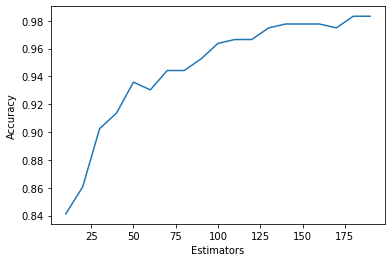

0.9832869080779945


<Figure size 432x288 with 0 Axes>

In [80]:
estimators = range(10, 200, 10)
total_accuracy = []
for i in estimators:
    boost = GradientBoostingClassifier(n_estimators=i).fit(X_train, y_train)
    boost_pred = boost.predict(X_test)

    total_accuracy.append(accuracy_score(y_test, boost_pred))

plt.plot(estimators, total_accuracy)
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('Boost.png')

print(np.array(total_accuracy).max())


# Clustering

### Estrategias de Clustering

Los algoritmos de clustering son las estrategias que podemos usar para agrupar los datos de tal manera que todos los datos pertenecientes a un grupo sean lo más similares que sea posible entre sí, y lo más diferentes a los de otros grupos.

#### Casos de aplicación de clustering.

1. No conocemos con anterioridad las etiquetas de nuestros datos (Aprendizaje no supervisado).
2. Queremos descubrir patrones ocultos a simple vista.
3. Queremos identificar datos atípicos.

#### Casos de uso de aplicación:

1. Cuando sabemos cuántos grupos “k” queremos en nuestro resultado.

Si es el caso, por ejemplo en una empresa de marketing y sabemos que los segmentos de clientes es bajo, medio alto, en este caso es recomendable usar k-means, o bien, spectral clustering.

2. Cuando queremos que el algoritmo descubra la cantidad de grupos “k” óptima según los datos que tenemos.

Por otro lado si no conocemos cuantos grupos o cuantas categories tenemos y solo queremos experimenter, la solución puede ser Meanshift, clustering jerárquico o DBScan.

### Meanshift

In [87]:
candy = pd.read_csv("./data/candy.csv")

X = candy.drop('competitorname', axis=1)

meanshift = MeanShift().fit(X)
print(max(meanshift.labels_))
print("="*64)
print(meanshift.cluster_centers_)

candy['meanshift'] = meanshift.labels_
print("="*64)


2
[[2.25000000e-01 5.75000000e-01 1.00000000e-01 2.50000000e-02
  5.00000000e-02 2.50000000e-02 3.00000000e-01 1.00000000e-01
  5.50000000e-01 4.57599993e-01 3.67824996e-01 4.10442122e+01]
 [4.68750000e-01 5.00000000e-01 1.25000000e-01 1.56250000e-01
  9.37500000e-02 6.25000000e-02 1.25000000e-01 3.12500000e-01
  5.31250000e-01 4.57281243e-01 4.67874998e-01 5.21138597e+01]
 [8.26086957e-01 1.73913043e-01 3.04347826e-01 3.04347826e-01
  1.73913043e-01 1.73913043e-01 0.00000000e+00 5.21739130e-01
  4.34782609e-01 5.81391293e-01 6.38086963e-01 6.47120799e+01]]


In [88]:
candy.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,meanshift
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725,2
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936,2
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086,0
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505,0
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465,1


<AxesSubplot:xlabel='sugarpercent', ylabel='pricepercent'>

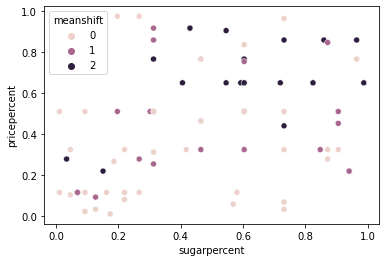

In [89]:
sns.scatterplot(data=candy,x='sugarpercent',y='pricepercent',hue='meanshift')

<AxesSubplot:xlabel='sugarpercent', ylabel='winpercent'>

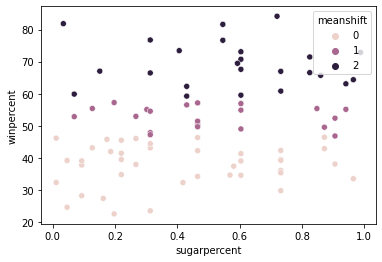

In [90]:
sns.scatterplot(data=candy,x='sugarpercent',y='winpercent',hue='meanshift')

## Implementación de Batch K-Means

In [94]:
kmeans = MiniBatchKMeans(n_clusters=4, batch_size=8).fit(X)

print('')
print('Total de centros:', len(kmeans.cluster_centers_))

print('')
print('Predicciones:', kmeans.predict(X))



Total de centros: 4

Predicciones: [0 0 1 3 2 2 2 1 3 1 3 1 1 3 3 3 3 3 2 1 2 3 2 0 2 2 1 2 0 3 3 2 0 0 3 2 0
 2 0 2 2 2 0 0 1 3 3 0 3 3 3 0 0 0 0 1 0 1 3 1 0 2 3 3 0 2 2 2 0 1 1 1 1 2
 2 3 3 2 3 0 3 3 3 3 2]


In [95]:
candy['Grupo'] = kmeans.predict(X)
candy.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,meanshift,Grupo
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725,2,0
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936,2,0
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086,0,1
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505,0,3
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465,1,2


In [ ]:

    # # Ahora mando los datos a un archivo excel :)

    # writer = pd.ExcelWriter('./K-Means/data/candy_usuario.xlsx', engine='xlsxwriter')
    # dataset.to_excel(writer, sheet_name='usuario')
    # writer.save()

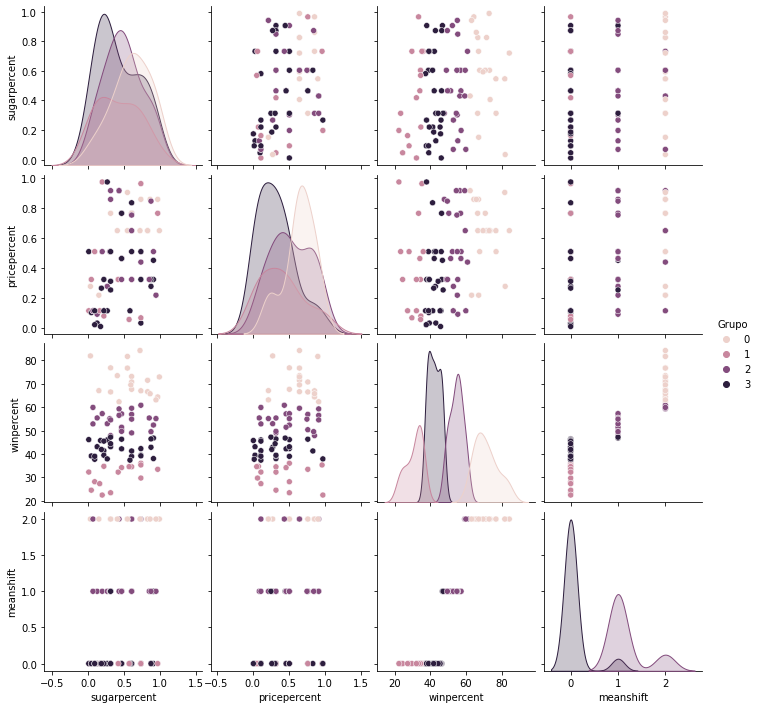

In [99]:
sns.pairplot(candy[['sugarpercent','pricepercent','winpercent','meanshift', 'Grupo']], hue = 'Grupo')

# Optimización paramétrica
## Validación de nuestro modelo usando Cross Validation

* La última palabra siempre la van a tener los datos.
* Todas nuestras intuiciones no tiene nada que hacer frente a lo que digan los datos y las matemáticas que aplicamos sobre estos datos. Por eso es importante siempre tener rigurosidad a la hora de evaluar los resultados que estamos recibiendo.
* Necesitamos mentalidad de testeo.
* No se trata solamente de probar un poco al principio y un poco al final, sino que tendremos que probar constantemente durante todo el proceso, para poder encontrar cuál es la solución óptima que realmente nos soluciona el problema que tenemos pendiente, todo esto:
 * con varias formas
 * con varios conjuntos de datos
 * con varias configuraciones de parámetros
 * con varias distribuciones de nuestros datos
* Todos los modelos son malos, solamente algunos son útiles.
* Todos los modelos que nosotros hacemos en últimas son una sobre simplificación de lo que pasa realmente. Entonces nunca nuestros modelos van a corresponder con la realidad al cien por ciento. Si jugamos lo suficiente y si somos lo suficientemente hábiles para configurar, vamos a llegar a un punto donde el modelo que estamos trabajando va a ser útil para ciertos casos específicos dentro del mundo real.
.
.
.
### Tipos de validación

#### Hold-Out

Se trata de dividir nuestros datos entrenamiento/pruebas, básicamente consiste en usar porcentajes fijos, por lo regular 70% de entrenamiento y 30% de pruebas.

![ho1](images/ho1.png)
![ho2](images/ho2.png)

¿Cuándo utilizar Hold-on?

* Se requiere un prototipado rápido.
* No se tiene mucho conocimiento en ML.
* No se cuenta con abundante poder de cómputo.
.
.
#### K-Folds
Usar validación cursada K-Fold, aquí vamos a plegar nuestros datos k veces, el k es un parámetro que nosotros definimos y en esos pliegues vamos a utilizar diferentes partes de nuestro dataset como entrenamiento y como test, de tal manera que intentemos cubrir todos los datos de entrenamiento y de test, al finalizar el proceso.

![kf1](images/kf1.png)
![kf2](images/kf2.png)

¿Cuándo utilizar K-Folds?

* Recomendable en la mayoría de los casos.

* Se cuenta con un equipo suficiente para desarrollar ML.

* Se require la integración con técnicas de optimización paramétrica.

* Se tiene más tiempo para las pruebas.
.
.

#### LOOCV

Validación cruzada LOOCV, Leave One Out Cross Validation. Este es el método más intensivo, ya que haremos una partición entre entrenamiento y pruebas, porque vamos a hacer entrenamiento con todos los datos, salvo 1 y vamos a repetir este proceso tantas veces hasta que todos los datos hayan sido probados.

![loocv](images/loocv.png)

¿Cuándo utilizar LOOCV?

* Se tiene gran poder de computo
* Se cuetan con pocos datos para poder dividir por Train/Test
* Cuando se quiere probar todos los casos posibles (para personas con TOC)

## Implementación de K-Folds Cross Validation

In [112]:
data = dataset.drop(["country","score"],axis=1)
targets = dataset["score"]

kf = KFold(n_splits=3,shuffle=True)
    
mse_values = []
for train,test in kf.split(data):
    x_train = pd.DataFrame(columns=list(data),index=range(len(train)))
    x_test = pd.DataFrame(columns=list(data),index=range(len(test)))
    y_train = pd.DataFrame(columns=['score'],index=range(len(train)))
    y_test = pd.DataFrame(columns=['score'],index=range(len(test)))
    for i in range(len(train)):
        x_train.iloc[i] = data.iloc[train[i]]
        y_train.iloc[i] = targets.iloc[train[i]]
    for j in range(len(test)):
        x_test.iloc[j] = data.iloc[test[j]]
        y_test.iloc[j] = targets.iloc[test[j]]
    model = DecisionTreeRegressor().fit(x_train,y_train)
    predict = model.predict(x_test)
    mse_values.append(mean_squared_error(y_test,predict))
    
print("Los tres MSE fueron: ",mse_values)
print("El MSE promedio fue: ", np.mean(mse_values))

Los tres MSE fueron:  [0.0025841373000757167, 0.0033665531718390235, 0.03112740415807746]
El MSE promedio fue:  0.012359364876664067


## Optimización de hiperparametros | Hyperparameter Optimization

Familiarizados con el concepto de Cross Validation vamos a utilizar este mismo principio de fondo para lograr automatizar un poco la selección y optimización de nuestros modelos.

**Problema:** Parece que encontramos un modelo de aprendizaje que parece funcionar, pero esto puede implicar que ahora tenemos que encontrar la optimización de cada uno de los parámetros de este modelo, encontrar el que mejor se ajuste y el que mejor resultado nos de.

1. Es facil perderse entre los conceptos de tantos parámetros. Tenemos flexibilidad para algoritmos básicos de Machine Learning, pero facil perderse.
2. Es difícil medir la sensibilidad de los mismos manualmente.
3. Es COSTOSO, en tiempo humano y computacionalmente.
Scikit Learn nos ofrece enfoques para automatizar el proceso de optimización paramétrica. Existen 3 enfoques principales, estos son:

1. Optimización manual

2. Optimizacion por grilla de parámetros | GridSearchCV

3. Optimizacion por búsqueda aleatorizada |
.
.
### Optimización manual

* Escoger el modelo que queremos ajustar.

* Buscar en la documentación de Scikit-Learn

* Identificar parámetros y ajustes. Parámetros que vamos a necesitar y cuáles son los posibles ajustes que vamos a requerir para cada uno de estos parámetros.

* Probar combinaciones una por una iterando a través de listas.
.
.
### Optimizacion por grilla de parámetros | GridSearchCV

Es una forma organizada, exhaustiva y sistematica de probar todos los parametros que le digamos que tenga que probar, con los respectivos rangos de valores que le aportemos.

* Definir una o varias métricas que queremos optimizar.
* Identificar los posibles valores que pueden tener los parámetros.
* Crear un diccionario de parámetros.
* Usar Cross Validation.
* Entrenar el modelo (e ir por un café)
La grilla de parámetros nos define GRUPOS DE PARÁMETROS que serán probados en todas sus combinaciones (Un grupo a la vez)

Ejemplo:

![grilla](images/grilla.png)
.
.

### Optimizacion por búsqueda aleatorizada | RandomizedSearchCV

Si no tenemos tanto tiempo para una prueba tan exhaustiva o queremos combinaciones aleatorias usaremos este metodo. Es lo mismo que el caso anterior, pero busca de forma aleatoria los parametros y Scikit Learn selecciona los mejores de las combinaciones aleatorias que se hicieron.

En este método, definimos escalas de valores para cada uno de los parámetros seleccionados, el sistema probará varias iteraciones (Configurables según los recursos) y mostrará la mejor combinación encontrada.

Ejemplo:

![rscv](images/rscv.png)
.
.

GridSearchCV vs RandomizedSearchCV

* GridSearchCV

 * Cuando se quiera realizar un estudio a fondo sobre las implicaciones de los parámetros.
 * Se tenga tiempo.
 * Se tenga poder de procesamiento.
* RandomizedSearchCV

 * Cuando se quiera explorar posibles optimizaciones.
 * Haya poco tiempo.
 * Haya poco poder de procesamiento.
![gvr](images/gvr.png)

## Implementación de Randomized

In [117]:
reg = RandomForestRegressor()

parametros = {
    'n_estimators' : range(4,16),
    'criterion' : ['squared_error', 'absolute_error'],
    'max_depth' : range(2,11)
}

rand_est = RandomizedSearchCV(reg, parametros , n_iter=10, cv=3, scoring='neg_mean_absolute_error').fit(X,y)

print(rand_est.best_estimator_)
print(rand_est.best_params_)
print(rand_est.predict(X.loc[[0]]))


RandomForestRegressor(criterion='absolute_error', max_depth=10, n_estimators=14)
{'n_estimators': 14, 'max_depth': 10, 'criterion': 'absolute_error'}
[7.5227858]


## Bonus: Auto Machine Learning

A estas alturas, después de ver la forma en la que scikit-learn nos permite semi-automatizar la optimización de nuestros modelos con GridSearchCV y RandomizedSearchCV es posible que te estés preguntando ¿Cuál es el límite de esta automatización?

Pues te sorprenderás,

Automated Machine Learning (AutoML), es un concepto relativamente nuevo que en general pretende la completa automatización de todo el proceso de Machine Learning, desde la extracción de los datos hasta su publicación final de cara a los usuarios.

Sin embargo, este ideal aún está en desarrollo en la mayoría de las etapas del proceso de Machine Learning y aún se depende bastante de la intervención humana. Aún con esto, es importante que seamos conscientes de que ya existen varias herramientas que nos acercan un poco a esta meta casi tomada de la ciencia ficción.

Puedes encontrar más información leyendo el siguiente enlace:

https://itmastersmag.com/noticias-analisis/que-es-automated-machine-learning-la-proxima-generacion-de-inteligencia-artificial/

La herramienta que te quiero presentar en esta clase se llama auto-sklearn, y nos ayudará a llevar aún un paso más lejos nuestro proceso de selección y optimización de modelos de machine learning. Dado que automáticamente prueba diferentes modelos predefinidos y configuraciones de parámetros comunes hasta encontrar la que más se ajuste según los datos que le pasemos como entrada. Con esta herramienta podrás entrenar modelos tanto de clasificación como de regresión por igual.

Para una lista de los clasificadores disponibles consulta:

https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/classification

Y para una lista de los regresores disponibles consulta:

https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/regression

Ten en cuenta que podrás añadir modelos personalizados al proceso siguiendo los pasos descritos en la documentación.

auto-sklearn:
Esta herramienta es una librería basada en los algoritmos de scikit-learn, aunque hay que tener presente que es una librería externa y se debe instalar siempre por aparte. En todo caso al ser una librería de Python se puede combinar sin ningún problema con el resto de nuestro código desarrollado para scikit-learn, incluso permitiendo la exportación de modelos ya entrenados para su posterior uso.

Enlace a la documentación: https://automl.github.io/auto-sklearn/master/index.html

Como lo puedes ver en su página web, los requerimientos para probar autosklearn son:

Se requiere un sistema operativo basado en Linux.

Python (>=3.5) .

Compilador para C++ (con soporte para C++11), por ejemplo GCC.

SWIG (versión 3.0 o superior).

La forma de hacer funcionar nuestro algoritmo no podría ser más fácil. Nos resultará bastante familiar a estas alturas después de haber trabajado tanto con sklearn.

import autosklearn.classification

cls = autosklearn.classification.AutoSklearnClassifier()

cls.fit(X_train, y_train)

predictions = cls.predict(X_test)

¡Te invito a conocer a fondo esta herramienta a través de su documentación y decidir si es la estrategia que estás buscando para tu problema específico!

# Salida a producción

## Revisión de nuestra arquitectura de código
Ahora vamos a convertir los scripts que tenemos en un código que sea modular y extensible con facilidad para que nuestra arquitectura pueda salir a producción de una manera exitosa.

Una estructura de carpetas que sea organizada para poder gestionar todo lo que vas a necesitar en cualquier proceso de Machine Learning.

Carpetas:

* in: Carpeta que contendrá archivos de entrada, datos que alimentarán a nuestros modelos.
* out: Carpeta que contendrá el resultado de la exportacion de nuestros modelos, visualizaciones, datos en excel o csv, etc.
* models: Carpeta que contedrá a los modelos.
Archivos:
Cada clase será un archivo que tenga su propia responsabilidad y se encargue específicamente de una tareas concreta.

* main.py: Metodo principal de ejecucion. Ejecutará todo el flujo de datos. Se encargaría de controlar el flujo de todo el código de principio a fin.
* load.py: Archivo que se encarga de cargar los datos desde in o una DB
* utils.py: Todos los metodos que se reutilizaran una y otra vez.
* models.py: Irá toda la parte de ML como tal.

## Importar y exportar modelos

Condensamos nuestro proyecto a 3 scripts: main.py, models.py y utils.py. Así:

main.py
```
from utils import Utils
from models import Models

if __name__ == "__main__":

    utils = Utils()
    models = Models()

    data = utils.load_from_csv('./in/felicidad.csv')
    X, y = utils.features_target(data, ['score','rank', 'country'],['score'])

    models.grid_training(X,y)

    print(data)
```

utils.py
```
import pandas as pd
import joblib

class Utils:

    def load_from_csv(self, path):
        return pd.read_csv(path)

    def load_from_mysql(self):
        pass

    def features_target(self, dataset, drop_cols, y):
        X = dataset.drop(drop_cols, axis=1)
        y = dataset[y]
        return X,y

    def model_export(self, clf, score):
        print(score)
        joblib.dump(clf, './models/best_model.pkl')
```

models.py
```
import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from utils import Utils

class Models:

    def __init__(self):
        self.reg = {
            'SVR' : SVR(),
            'GRADIENT' : GradientBoostingRegressor()
        }

        self.params = {
           'SVR' : {
               'kernel' : ['linear', 'poly', 'rbf'],
               'gamma' : ['auto', 'scale'],
               'C' : [1,5,10]
           }, 'GRADIENT' : {
               'loss' : ['squared_error', 'absolute_error'],
               'learning_rate' : [0.01, 0.05, 0.1]
           }
        }

    def grid_training(self, X,y):

        best_score = 999
        best_model = None

        for name, reg in self.reg.items():

            grid_reg = GridSearchCV(reg, self.params[name], cv=3).fit(X, y.values.ravel())
            score = np.abs(grid_reg.best_score_)

            if score < best_score:
                best_score = score
                best_model = grid_reg.best_estimator_
        

        utils = Utils()
        utils.model_export(best_model, best_score)

```

## Creación de una API con Flask para el modelo

Creación de script server.py con flask

server.py
```
import joblib
import numpy as np

from flask import Flask
from flask import jsonify

app = Flask(__name__)

#POSTMAN PARA PRUEBAS
@app.route('/predict', methods=['GET'])
def predict():
    X_test = np.array([7.594444821,7.479555538,1.616463184,1.53352356,0.796666503,0.635422587,0.362012237,0.315963835,2.277026653])
    prediction = model.predict(X_test.reshape(1,-1))
    return jsonify({'prediccion' : list(prediction)})

if __name__ == "__main__":
    model = joblib.load('./models/best_model.pkl')
    app.run(port=8080)
```

# Material adicional para consultar

Una vez más debo felicitarte por haber llegado hasta el final de este curso. ¡Si multiplicamos nuestro conocimiento y lo compartimos con otros, cada vez haremos mejores productos tecnológicos que nos beneficien a todos!

¡Nunca pares de aprender!

No quiero irme sin recordarte que todo lo que vimos en este curso es no más una muestra del apasionante mundo del machine learning. Y te quiero dejar algunos materiales para que puedas continuar con tu camino de aprendizaje infinito. Si encuentras algún material que valga la pena, no dudes en hacérmelo llegar también. Juntos podemos llegar más lejos.

Machine Learning & Data Science:
El canal de StatQuest con Josh Starmer (Inglés):

https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw

El canal de SentDex (Inglés):

https://www.youtube.com/user/sentdex

Un blog especializado en Data Science (Inglés)

https://towardsdatascience.com/

Libro gratuito: The art of data science (Inglés)

https://bookdown.org/rdpeng/artofdatascience/

Canal AMP Tech: (Español)

https://www.youtube.com/channel/UCG4H4Qf-ZU9Ycr_PQ4egqDQ

Tensorflow Coding (Español):

https://www.youtube.com/watch?v=ZMkYL942RBw&list=PLQY2H8rRoyvz3rEFpW2I3gPSru5xm8Bf7

Canal de 3Blue1Brown (Subtitulado):

https://www.youtube.com/watch?v=aircAruvnKk

El curso de Deep Learning para PLN de Stanford: http://web.stanford.edu/class/cs224n/

El canal de Daniel Shiffman “The Coding Train”

(Está más orientado a temas de computación gráfica, pero las explicaciones que da de Inteligencia Artificial son maravillosas).

https://www.youtube.com/user/shiffman

El libro de Daniel Shiffman de introducción a la vida artificial usando P5.JS (Javascript):

https://natureofcode.com/book/

El canal de Andrew Ng. Deeplearning.ai

https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w

Mis comunidades favoritas en facebook:
(No olvides revisar la sección de archivos cuando sea el caso)

The Data Pub:

https://www.facebook.com/thedatapub/

Machine Learning Colombia:

https://www.facebook.com/groups/1766056600304468/files/

Machine Learning en Español

https://www.facebook.com/groups/machinelearninges/

Sociedad Ecuatoriana de estadística (Español)

https://www.facebook.com/socecuest/

Con mucho cariño,

Ariel Ortiz Beltrán.
